# Задача
одна из проблем, которую мы видим при обращении в саппорт - в разрезе разных категорий обращения необходимо смотреть в разные сервисы и собирать дополнительную информацию. На это уходит много времени. на одно обращение уходит в среднем 2 минуты поиска дополнительной информации. Стоимость часа работы сотрудника 6$.

Давайте поможем и оптимизируем время и деньги компании - сделаем модель,которая в зависимости от текста будет определять категорию обращения автоматически.

Тогда мы сможем сразу подготавливать информацию для наших операторов в течение 5 секунд (сбор и передача на фронт)

Нужно сделать модель многоклассовой классификации определения категории обращения

# загружаем данные

In [180]:
#!pip install sumy

In [ ]:
#!pip install stop_words

  Created wheel for stop-words: filename=stop_words-2018.7.23-cp36-none-any.whl size=32916 sha256=d035fc6debf21c996f5ffe8129d8179d3ecc0cf0127771a4120807e7abb09027
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer

import datetime
import requests
import collections as co
import string
import re

import nltk
from sumy.utils import get_stop_words as gsw1
from stop_words import get_stop_words as gsw2


import pandas as pd
import numpy as np

In [ ]:

from io import StringIO

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('3categories_50.csv')
df.shape

(50000, 3)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
df.head(2)

,channel,category,message
0,chat,afs,\nChat transcript:\nVisitor: I am attempting t...
1,chat,other,\nChat transcript:\nVisitor: Hi. For some reas...


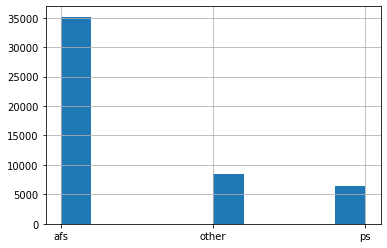

In [ ]:
df['category'].hist()

# прежде всего очистка данных

In [ ]:
#убираем технические данные в сообщениях и прочий шум
df['message'] = df['message'].str.replace('\[.*\]', '', regex=True)

df['message'] = df['message'].str.replace("\!", '', regex=True)
df['message'] = df['message'].str.replace("\'", '', regex=True)

df['message'] = df['message'].str.replace("[^A-Za-z0-9^,!.\/'+-=]", ' ', regex=True)


In [ ]:
#переведем в нижний регистр
df['message'] = df['message'].str.replace("\s+", ' ', regex=True)
df['message'] = df['message'].str.lower()

In [ ]:
#уберем шум
df.dropna(inplace = True)
df.shape

(49999, 3)

In [ ]:
# уберем шумовые длинные сообщения
df['message_len'] = df['message'].str.len()

df = df[(df['message_len'] < np.percentile(df.message_len,99))][:]

df.shape

(49499, 4)

# очистим весь наш текст от шумовых слов и преобразуем к первообразным формам


In [ ]:
#давайте попробуем очистить от шума наши сообщения и создадим новый текст очищенный от мусора

In [ ]:
df_reviews = df[['message']][:]
df_reviews.columns = ['review']
df_reviews.reset_index(drop = True , inplace = True)
df_reviews.head(2)

,review
0,chat transcript: visitor: i am attempting to ...
1,chat transcript: visitor: hi. for some reason...


In [ ]:

list_count_words = []
list_true_words = []
list_tagged = []
list_tags = []

for i ,row in  df_reviews.iterrows():
    words = []
    tagged = []
    true_words = []
    tags = []
    
    a_line = row['review']

    
    try:
        words = re.split(' ', a_line)
        true_words = []

        for word in words:
            m = re.search('(\w+)',word)
            if m is not None:
                good_word = m.group(0)
                true_words.append(good_word)

        tagged = nltk.pos_tag(true_words)
        tags = []
        for tag in tagged:
            tags.append(tag[1])
    except:
        pass



    list_count_words.append(len(words))   
    list_tagged.append(tagged)
    list_true_words.append(true_words)
    list_tags.append(tags)


In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
df_reviews['count_words'] = list_count_words
df_reviews['list_of_words'] = list_true_words

df_reviews['list_of_tags'] = list_tags
df_reviews['word_with_tag_list'] = list_tagged


In [ ]:
text_analizator_df = df_reviews[:]
text_analizator_df.rename(columns = {'review' : 'sentence'} , inplace = True)
text_analizator_df.head()

,sentence,count_words,list_of_words,list_of_tags,word_with_tag_list
0,chat transcript: visitor: i am attempting to ...,58,"[chat, transcript, visitor, i, am, attempting,...","[RB, JJ, NN, NN, VBP, VBG, TO, VB, PRP$, NN, R...","[(chat, RB), (transcript, JJ), (visitor, NN), ..."
1,chat transcript: visitor: hi. for some reason...,113,"[chat, transcript, visitor, hi, for, some, rea...","[RB, JJ, NN, NN, IN, DT, NN, PRP, VBZ, IN, PRP...","[(chat, RB), (transcript, JJ), (visitor, NN), ..."
2,"chat transcript: visitor: , faceit, andrew: ....",50,"[chat, transcript, visitor, faceit, andrew, vi...","[RB, JJ, NN, NN, VBD, NN, NN, NN, VBD, TO, VB,...","[(chat, RB), (transcript, JJ), (visitor, NN), ..."
3,chat transcript: visitor: no puedo hacer la r...,157,"[chat, transcript, visitor, no, puedo, hacer, ...","[RB, JJ, NN, DT, NN, NN, FW, FW, FW, NN, VBD, ...","[(chat, RB), (transcript, JJ), (visitor, NN), ..."
4,chat transcript: visitor: hi im trying to buy...,110,"[chat, transcript, visitor, hi, im, trying, to...","[RB, JJ, NN, NN, NN, VBG, TO, VB, NNS, CC, PRP...","[(chat, RB), (transcript, JJ), (visitor, NN), ..."


In [ ]:
#получили новое смысловое описание атрибутов текста, видно много местоимений и другой информации, давайте очистим

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopWords =nltk.corpus.stopwords.words()

LANGUAGE = 'english'

sw0 = ["yeah","zola","don"]
sw1 = gsw1(LANGUAGE)
sw2 = gsw2('en')

sw0.extend(list(sw1))
sw0.extend(list(sw2))



new_s_list = []
new_lw_list = []
new_lt_list = []
new_lwt_list = []
new_count_words = []

for s , lw , lt ,lwt in zip (text_analizator_df['sentence'] 
                        , text_analizator_df['list_of_words'] 
                        , text_analizator_df['list_of_tags']
                        , text_analizator_df['word_with_tag_list']):
    new_s = ''
    new_lw = []
    new_lt = []
    new_lwt = []
    for w,t,lw in zip(lw,lt,lwt):
        if t in ['NN','VB','DT','NNS','VBP','VB']:
            new_s += w + ' '
            new_lw.append(w)
            new_lt.append(t)
            new_lwt.append(lw)
        elif w in sw0 or re.match('\d+',w) is not None:
            continue

    
    new_s_list.append(new_s)
    new_lw_list.append(new_lw)
    new_lt_list.append(new_lt)
    new_lwt_list.append(new_lwt)
    new_count_words.append(len(new_lw))
        
text_analizator_df['new_sentence'] = new_s_list
text_analizator_df['list_of_words'] = new_lw_list
text_analizator_df['list_of_tags'] = new_lt_list
text_analizator_df['word_with_tag_list'] = new_lwt_list
text_analizator_df['count_words'] = new_count_words


In [ ]:
#import nltk 
#nltk.download('stopwords')

In [ ]:
# в итоге выделив основные главне слова, которые нам могут быть интересны потенциально
# получили new_sentence, можнте посмотреть как он отличается
print(f'old- {text_analizator_df.loc[0]["sentence"]}' )
print('\n')
print(f'new -{text_analizator_df.loc[0]["new_sentence"]}' )

old-  chat transcript: visitor: i am attempting to verify my card however the payment is not posting. all charges typically post immediately with my bank. sofia: hello sofia: please stand by online, as it may take some time to resolve the issue. ill provide you with an update in a few minutes. thank you for your patience. 


new -visitor i am verify card the payment all charges post bank sofia hello sofia please stand online take some time resolve the issue ill an update a minutes thank patience 


In [ ]:
text_analizator_df.head()

,sentence,count_words,list_of_words,list_of_tags,word_with_tag_list,new_sentence
0,chat transcript: visitor: i am attempting to ...,30,"[visitor, i, am, verify, card, the, payment, a...","[NN, NN, VBP, VB, NN, DT, NN, DT, NNS, VBP, NN...","[(visitor, NN), (i, NN), (am, VBP), (verify, V...",visitor i am verify card the payment all charg...
1,chat transcript: visitor: hi. for some reason...,64,"[visitor, hi, some, reason, sub, prepcoin, nl,...","[NN, NN, DT, NN, NN, NN, NN, NN, VBP, NN, NN, ...","[(visitor, NN), (hi, NN), (some, DT), (reason,...",visitor hi some reason sub prepcoin nl didnt g...
2,"chat transcript: visitor: , faceit, andrew: ....",17,"[visitor, faceit, visitor, hello, i, pay, a, s...","[NN, NN, NN, NN, NN, VB, DT, NN, DT, NN, NN, D...","[(visitor, NN), (faceit, NN), (visitor, NN), (...",visitor faceit visitor hello i pay a subscript...
3,chat transcript: visitor: no puedo hacer la r...,80,"[visitor, no, puedo, hacer, cash, infelizmente...","[NN, DT, NN, NN, NN, NN, NN, DT, NN, NN, NN, N...","[(visitor, NN), (no, DT), (puedo, NN), (hacer,...",visitor no puedo hacer cash infelizmente yo no...
4,chat transcript: visitor: hi im trying to buy...,48,"[visitor, hi, im, buy, bits, payment, be, hell...","[NN, NN, NN, VB, NNS, NN, VB, NN, NN, VB, DT, ...","[(visitor, NN), (hi, NN), (im, NN), (buy, VB),...",visitor hi im buy bits payment be hello im add...


# генерация вектора
Давайте попробуем оставить только важные слова

In [ ]:
text_analizator_df['text_arr'] = text_analizator_df.new_sentence.str.split('\W+').tolist()

In [ ]:
#сделаем массив из всех слов, разделенных пробелами, которые могут встречаться
text_arrays = text_analizator_df['text_arr'].tolist()
text_arrays = np.concatenate( text_arrays, axis=0 )


In [ ]:
#уберем все пустые строки
text_arrays = list( text_arrays)
text_arrays = list(filter(None, text_arrays))

Text(0.5, 1.0, 'Top Words')

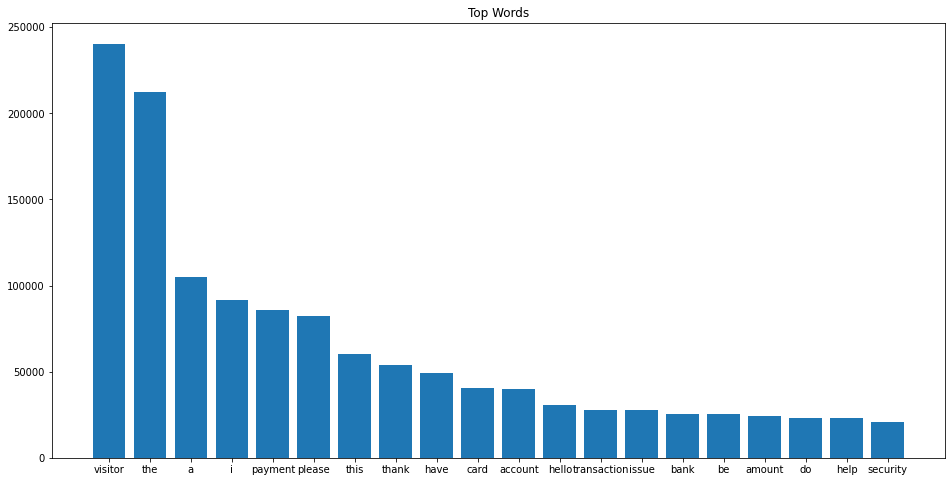

In [ ]:
#проанализируем популярные слова
from sklearn.feature_extraction.text import CountVectorizer

c_text = co.Counter(text_arrays)

w =[]
count_w = []


most_freq_words = []

for i in c_text.most_common(20):
    w.append(i[0])
    count_w.append(i[1])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(w)), count_w)
ax.set_xticks(range(len(w)))
ax.set_xticklabels(w)
ax.set_title('Top Words')

In [ ]:
#посмотрим непопулярные слова мало ли там беда
pd.DataFrame.from_dict(dict(c_text) , orient = 'index').sort_values(by = 0).head(15)

#видно в непопулярных словах какой то треш, они явно бесполезны при создании нашей модели, идем верно

,0
bayaga,1
lete,1
a1908111649410105,1
whar,1
photot,1
messengers,1
a1902101042404851,1
hellou,1
hdzuax958w7b,1
ajaxx,1


# стемминг
важной частью задач nlp является преобразование к первоначальной форме, т.к. мы сужаем область поиска для слов

In [ ]:
text_analizator_df['text_arr'] = text_analizator_df.new_sentence.str.split('\W+').tolist()

In [ ]:
from nltk.stem.porter import *
stemming = PorterStemmer()

def stem_list(row):
    my_list = row['text_arr']
    stemmed_list = [stemming.stem(word) for word in my_list]
    return (stemmed_list)

text_analizator_df['stem_arr'] = text_analizator_df.apply(stem_list, axis=1)


In [ ]:
text_arrays = text_analizator_df['stem_arr'].tolist()
text_arrays = np.concatenate( text_arrays, axis=0 )


Text(0.5, 1.0, 'Top Words')

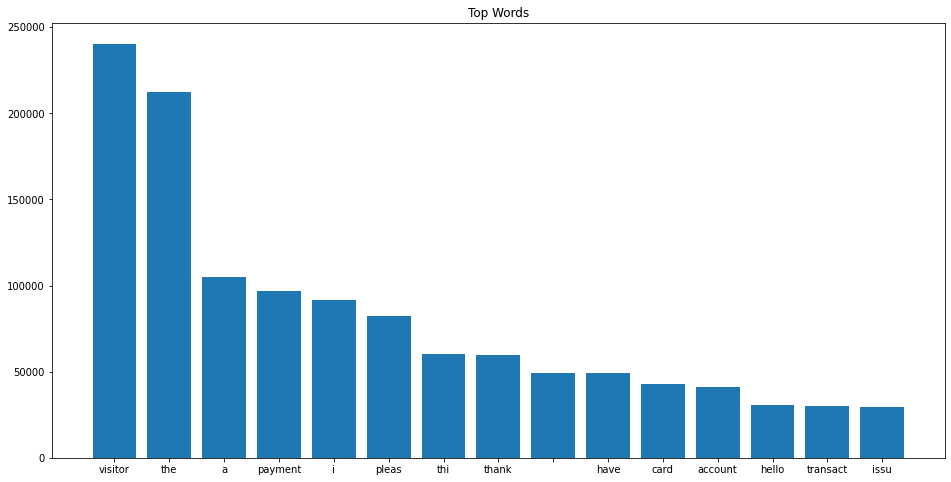

In [ ]:
#отлично видим что наши частовстречающиеся слова однородны
c_text = co.Counter(text_arrays)

w =[]
count_w = []


most_freq_words = []

for i in c_text.most_common(15):
    w.append(i[0])
    count_w.append(i[1])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(w)), count_w)
ax.set_xticks(range(len(w)))
ax.set_xticklabels(w)
ax.set_title('Top Words')

In [ ]:
# мы хотим попробовать подход tf-idf над словами, для того, чтобы веса были равномерны - давайте выберем наиболее корректные слова
top_words = 1500
pd.DataFrame.from_dict(dict(c_text) , orient = 'index').sort_values(by = 0,ascending = False).head(top_words)

,0
visitor,240422
the,212603
a,104749
payment,96947
i,91611
...,...
doubl,76
session,76
embargo,76
maalesef,76


In [ ]:
#оставим для модели топ  слов
final_words = pd.DataFrame.from_dict(dict(c_text) , orient = 'index').sort_values(by = 0 , ascending = False).head(top_words).index.values

In [ ]:
f = lambda x: ' '.join([item for item in x if item in final_words])
text_analizator_df['stem_text'] = text_analizator_df['stem_arr'].apply(f)

In [ ]:
# в итоге выделив основные главне слова, которые нам могут быть интересны потенциально
# получили new_sentence, можнте посмотреть как он отличается
print(f'old- {text_analizator_df.loc[0]["sentence"]}' )
print('\n')
print(f'new -{text_analizator_df.loc[0]["new_sentence"]}' )
print('\n')
print(f'stem -{text_analizator_df.loc[0]["stem_text"]}' )

old-  chat transcript: visitor: i am attempting to verify my card however the payment is not posting. all charges typically post immediately with my bank. sofia: hello sofia: please stand by online, as it may take some time to resolve the issue. ill provide you with an update in a few minutes. thank you for your patience. 


new -visitor i am verify card the payment all charges post bank sofia hello sofia please stand online take some time resolve the issue ill an update a minutes thank patience 


stem -visitor i am verifi card the payment all charg post bank sofia hello sofia pleas stand onlin take some time resolv the issu ill an updat a minut thank patienc 


# сделаем теперь векторное представление

In [ ]:
#ну тут без особой магии
texts = df['message']
texts = text_analizator_df['sentence']
texts = text_analizator_df['stem_text']

vec = TfidfVectorizer(max_features=top_words)
tfidf_mat = vec.fit_transform(texts).toarray()
print(type(tfidf_mat),tfidf_mat.shape)
#на выход получаем матрицу заданной размерности

<class 'numpy.ndarray'> (49499, 1474)


# выравнивание классов

In [ ]:
train = pd.DataFrame(tfidf_mat)
train['category'] =  df['category']

target = 'category'
train_columns = list(set(train.columns) - set([target]))

train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1435,1436,1437,1438,1439,1440,1441,1442,1443,1444,1445,1446,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1465,1466,1467,1468,1469,1470,1471,1472,1473,category
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,afs
1,0.0,0.0,0.0,0.0,0.0,0.0,0.173964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,other
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,afs
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.108642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,afs
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,afs


In [ ]:
train.dropna(inplace = True)

In [ ]:
#переводим в инты таргет
labels, levels = pd.factorize(train[target])
train['category_int'] = labels

target = 'category_int'

In [ ]:
train[(train['category_int'] == -1)]
train.category.unique()

array(['afs', 'other', 'ps'], dtype=object)

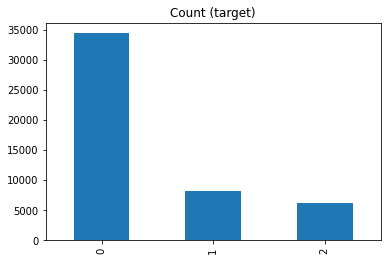

In [ ]:
train[target].value_counts().plot(kind='bar', title='Count (target)');

In [ ]:
#сделаем оверсемплинг

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(train[train_columns], train[target])

print(f'rate target detect fight in game {sum(y_ros) / X_ros.shape[0]}')

y_ros.value_counts().plot(kind='bar', title='Count (target)');


In [ ]:
X_ros[target] = y_ros
train = X_ros[:]

# наконец переходим к модели

In [ ]:
#будем использовать LightGBM как основной фреймворк для построения модели
# попробуем?
import lightgbm as lgb

from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [80]:
#отложим выборку для финальной оценки

# уменьшила выборку т.к. не тащит ноут

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train[train_columns][0:10000]
                                                    , train[target][0:10000] 
                                                    , test_size=0.2
                                                    , random_state=400 
                                                    , stratify = train[target][0:10000] 
                                                   )

print(f'Train set: {x_train.shape[0]} size , {sum(y_train) / x_train.shape[0]} target size')
print(f'Test set: {x_test.shape[0]} size , {sum(y_test) / x_test.shape[0]} target size')


Train set: 8000 size , 0.42075 target size
Test set: 2000 size , 0.4205 target size


In [ ]:
#а давайте попробуем бустинг
from sklearn.model_selection import RepeatedStratifiedKFold , StratifiedKFold
skf = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=22031990)
skf = StratifiedKFold(n_splits=3, random_state=22031990, shuffle=False)

In [ ]:
lgb_data_train = lgb.Dataset(x_train[train_columns], 
                             y_train, 
                             free_raw_data=False
                            )

#инициируем целевые параметры для первого приближения модели
#можете детальнее посмотреть тут https://lightgbm.readthedocs.io/en/latest/Parameters.html
params = {
    'objective':'multiclass', 
    'metric': 'multi_logloss',
    "num_class" : 3,
    'learning_rate': 0.01, 
    'random_state':202008,
    'subsample':0.33,
    'colsample_bytree':0.33,
    'reg_lambda':4
}


h = lgb.cv(params, 
           lgb_data_train, 
           num_boost_round=500,
           early_stopping_rounds=50, 
           verbose_eval=10, 
           folds=skf.split(x_train[train_columns], y_train)
          )



In [ ]:
#можно еще поиграться с гипероптом? :)
optimal_boost = 200
lgb_data_train = lgb.Dataset(x_train[train_columns], 
                             y_train, 
                             free_raw_data=False
                            )


model = lgb.train(params, lgb_data_train, num_boost_round=optimal_boost  )

In [ ]:
predicts_prob = model.predict(x_test)
prediction_class = []

for x in predicts_prob:
    prediction_class.append(np.argmax(x))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


#one
predict_i = model.predict(np.array([cv_result[0]]))
#many
predict_i = model.predict(cv_result[0:])

y_pred = predict_i.argmax(axis=-1)
y_target = target.argmax(axis=-1)


cm = confusion_matrix(y_target=y_,
                      y_predicted=y_pred)

fig, ax = plot_confusion_matrix(conf_mat=cm)

ig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
#fig.savefig('test2png.png', dpi=100)
plt.show()

# Моя модель

In [173]:
#сохраняем векторайзер
import pickle 

labels, levels = pd.factorize(df['category'])
df['category_int'] = labels

texts = df['message']

vec = TfidfVectorizer(max_features=100)
tfidf_mat = vec.fit_transform(texts).toarray()

#сохраняем модель в файл
pickle.dump(vec, open("tfidf.pickle", "wb"))

#загружаем модель из файла
vec = pickle.load(open("tfidf.pickle", "rb"))

In [174]:
#### сохраняем бустинг

train = pd.DataFrame(tfidf_mat)
train['category_int'] = df['category_int']

train.dropna(inplace = True)

target = 'category_int'
train_columns = list(set(train.columns) - set([target]))

In [175]:
# CNN

import keras
embedding_dim = 100

model = keras.Sequential([keras.layers.Embedding (400, embedding_dim, input_length=100),
keras.layers.Conv1D(128, 5, activation='relu'),
keras.layers.GlobalMaxPooling1D(),
keras.layers.Dense(10, activation='relu'),
keras.layers.Dense(1, activation='sigmoid')]) 
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train,
                    epochs=10, # эпохи
                    verbose=False,
                    validation_data=(x_test, y_test),
                    batch_size=10)

# Сохраним всю модель в файл HDF5
model.save('my_model.h5')

In [176]:
# Пересоздадим в точности эту модель включая веса и оптимизатор.
model = keras.models.load_model('my_model.h5')

In [177]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7063
Testing Accuracy:  0.7065


In [179]:
message = 'hello i want to payment but it is blocked'
model.predict_classes(vec.transform([message]).toarray())

array([[0]], dtype=int32)